## (Automatic differentiation)

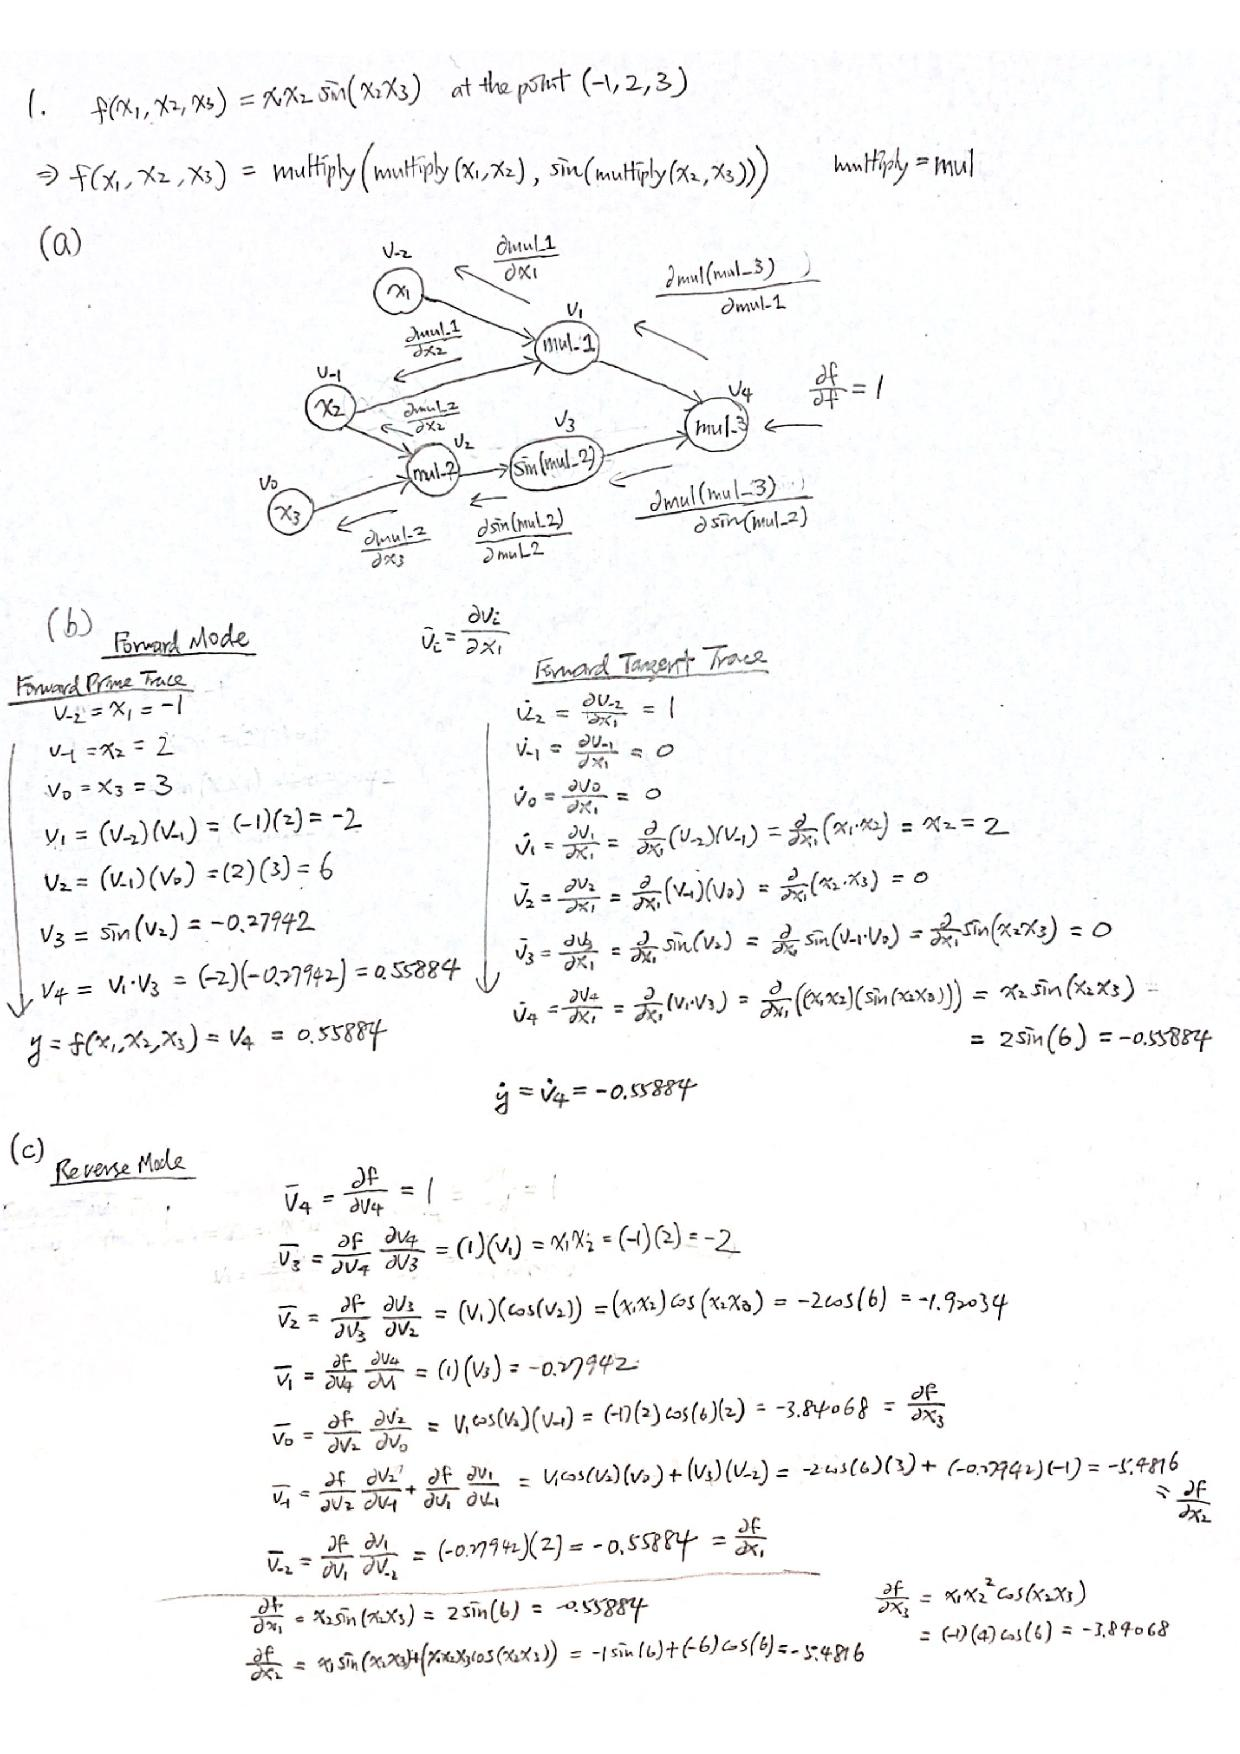

In [1]:
import numpy as np

class Graph():
    """ Computational graph class. 
    Initilizes a global variable _g that describes the graph.
    Each graph consists of a set of
        1. operators
        2. variables
        3. constants
        4. placeholders
    """
    def __init__(self):
        self.operators = set()
        self.constants = set()
        self.variables = set()
        self.placeholders = set()
        global _g
        _g = self
        
    def reset_counts(self, root):
        if hasattr(root, 'count'):
            root.count = 0
        else:
            for child in root.__subclasses__():
                self.reset_counts(child)

    def reset_session(self):
        try:
            del _g
        except:
            pass
        self.reset_counts(Node)
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.reset_session()

In [4]:

class Node:
    def __init__(self):
        pass
      
 ### Placeholders ###
class Placeholder(Node):
    """An placeholder node in the computational graph. This holds
    a node, and awaits further input at computation time.
    Args: 
        name: defaults to "Plc/"+count
        dtype: the type that the node holds, float, int, etc.
    """
    count = 0
    def __init__(self, name, dtype=float):
        _g.placeholders.add(self)
        self.value = None
        self.gradient = None
        self.name = f"Plc/{Placeholder.count}" if name is None else name
        Placeholder.count += 1
        
    def __repr__(self):
        return f"Placeholder: name:{self.name}, value:{self.value}"
        
### Constants ###      
class Constant(Node):
    """A constant node in the computational graph.
    Args: 
        name: defaults to "const/"+count
        value: a property protected value that prevents user 
               from reassigning value
    """
    count = 0
    def __init__(self, value, name=None):
        _g.constants.add(self)
        self._value = value
        self.gradient = None
        self.name = f"Const/{Constant.count}" if name is None else name
        Constant.count += 1
        
    def __repr__(self):
        return f"Constant: name:{self.name}, value:{self.value}"
    
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self):
        raise ValueError("Cannot reassign constant")
        self.value = None
        self.gradient = None
        self.name = f"Plc/{Placeholder.count}" if name is None else name
        Placeholder.count += 1
        
    def __repr__(self):
        return f"Placeholder: name:{self.name}, value:{self.value}"
      
### Variables ###
class Variable(Node):
    """An variable node in the computational graph. Variables are
    automatically tracked during graph computation.
    Args: 
        name: defaults to "var/"+count
        value: a mutable value
    """
    count = 0
    def __init__(self, value, name=None):
        _g.variables.add(self)
        self.value = value
        self.gradient = None
        self.name = f"Var/{Variable.count}" if name is None else name
        Variable.count += 1
        
    def __repr__(self):
        return f"Variable: name:{self.name}, value:{self.value}"
      
### Operators ###
class Operator(Node):
    """An operator node in the computational graph.
    Args: 
        name: defaults to "operator name/"+count
    """
    def __init__(self, name='Operator'):
        _g.operators.add(self)
        self.value = None
        self.inputs = []
        self.gradient = None
        self.name = name
    
    def __repr__(self):
        return f"Operator: name:{self.name}"

In [5]:
##### Fundamental Operator Definitions #####
class add(Operator):
    count = 0
    """Binary addition operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'add/{add.count}' if name is None else name
        add.count += 1
        
    def forward(self, a, b):
        return a+b
    
    def backward(self, a, b, dout):
        return dout, dout

class multiply(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'mul/{multiply.count}' if name is None else name
        multiply.count += 1
        
    def forward(self, a, b):
        return a*b
    
    def backward(self, a, b, dout):
        return dout*b, dout*a
    
class divide(Operator):
    count = 0
    """Binary division operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'div/{divide.count}' if name is None else name
        divide.count += 1
   
    def forward(self, a, b):
        return a/b
    
    def backward(self, a, b, dout):
        return dout/b, dout*a/np.power(b, 2)
    
    
class power(Operator):
    count = 0
    """Binary exponentiation operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'pow/{power.count}' if name is None else name
        power.count += 1
   
    def forward(self, a, b):
        return np.power(a, b)
    
    def backward(self, a, b, dout):
        return dout*b*np.power(a, (b-1)), dout*np.log(a)*np.power(a, b)
    
class matmul(Operator):
    count = 0
    """Binary multiplication operation."""
    def __init__(self, a, b, name=None):
        super().__init__(name)
        self.inputs=[a, b]
        self.name = f'matmul/{matmul.count}' if name is None else name
        matmul.count += 1
        
    def forward(self, a, b):
        return a@b
    
    def backward(self, a, b, dout):
        return dout@b.T, a.T@dout
    
    
#####       Operator overloading       #####
def node_wrapper(func, self, other):
    """ Check to make sure that the two things we're comparing are
    actually graph nodes. Also, if we use a constant, automatically
    make a Constant node for it"""
    if isinstance(other, Node):
        return func(self, other)
    if isinstance(other, float) or isinstance(other, int):
        return func(self, Constant(other))
    raise TypeError("Incompatible types.")

Node.__add__ = lambda self, other: node_wrapper(add, self, other)
Node.__mul__ = lambda self, other: node_wrapper(multiply, self, other)
Node.__div__ = lambda self, other: node_wrapper(divide, self, other)
Node.__neg__ = lambda self: node_wrapper(multiply, self, Constant(-1))
Node.__pow__ = lambda self, other: node_wrapper(power, self, other)
Node.__matmul__ = lambda self, other: node_wrapper(matmul, self, other)

In [28]:
#####  Topological sort  #####
def topological_sort(head_node=None, graph=_g):
    """Performs topological sort of all nodes prior to and 
    including the head_node. 
    Args:
        graph: the computational graph. This is the global value by default
        head_node: last node in the forward pass. The "result" of the graph.
    Returns:
        a sorted array of graph nodes.
    """
    vis = set()
    ordering = []
    
    def _dfs(node):
        if node not in vis:
            vis.add(node)
            if isinstance(node, Operator):
                for input_node in node.inputs:
                    _dfs(input_node)
            ordering.append(node)
            
    if head_node is None:
        for node in graph.operators:
            _dfs(node)
    else:
        _dfs(head_node)
        
    return ordering
    
#####    Forward pass    #####
def forward_pass(order, feed_dict={}):
    """ Performs the forward pass, returning the output of the graph.
    Args:
        order: a topologically sorted array of nodes
        feed_dict: a dictionary values for placeholders.
    Returns:
        1. the final result of the forward pass.
        2. directly edits the graph to fill in its current values.
    """
    for node in order:
        
        if isinstance(node, Placeholder):
            node.value = feed_dict[node.name]
                    
        elif isinstance(node, Operator):
            node.value = node.forward(*[prev_node.value for prev_node in node.inputs])

    return order[-1].value
    
#####    Backward pass   #####
def backward_pass(order, target_node=None):
    """ Perform the backward pass to retrieve gradients.
    Args:
        order: a topologically sorted array of graph nodes.
               by default, this assigns the graident of the final node to 1
    Returns:
        gradients of nodes as listed in same order as input argument
    """
    vis = set()
    order[-1].gradient = 1
    for node in reversed(order):
        if isinstance(node, Operator):
            inputs = node.inputs
            grads = node.backward(*[x.value for x in inputs], dout=node.gradient)
            for inp, grad in zip(inputs, grads):
                if inp not in vis:
                    inp.gradient = grad
                else:
                    inp.gradient += grad
                vis.add(inp)
    return [node.gradient for node in order]

In [32]:
import math

va1=-1
va2=2
va3=3

with Graph() as g:
    x1 = Variable(val1, name='x1')
    x2 = Variable(val2, name='x2')
    x3 = Variable(val3, name='x3')
    z = x1*x2*math.sin(6)
    order = topological_sort(z)
    res = forward_pass(order)
    grads = backward_pass(order)
    print("Node ordering:")
    for node in order:
        print(node) 
    print('-'*10)
    print(f"Forward pass expected: {(val1*val2+val3)*val3+val1}")
    print(f"Forward pass computed: {res}")

Node ordering:
Variable: name:x1, value:-1
Variable: name:x2, value:2
Operator: name:mul/0
Placeholder: name:Const/0, value:-0.27941549819892586
Operator: name:mul/1
----------
Forward pass expected: 2
Forward pass computed: 0.5588309963978517


In [34]:
dydx1_node = [a for a in order if a.name=='x1'][0]
dydx2_node = [a for a in order if a.name=='x2'][0]
dydx3_node = [a for a in order if a.name=='x3'][0]
print(f"dy/dx1 expected = {x2*math.sin(6)}")
print(f"dy/dx1 computed = {dydx1_node.gradient}")
print(f"dy/dx2 expected = {x1*math.sin(x2*x3)+x1*x2*x3*cos(x2*x3)}")
print(f"dy/dx2 computed = {dydx2_node.gradient}")
print(f"dy/dx3 expected = {x1*x2**2*cos(x2*x3)}")
print(f"dy/dx3 computed = {dydx3_node.gradient}")

IndexError: list index out of range

## (Generative adversarial network)

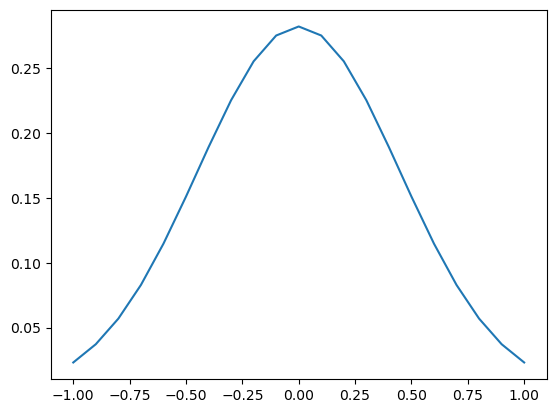

In [1]:
from matplotlib import pyplot
import math

 
# simple function
def calculate(x):
    return 0.28209*math.exp(-x**2/0.4)
 
# define inputs
inputs = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# calculate outputs
outputs = [calculate(x) for x in inputs]

# plot the result
pyplot.plot(inputs, outputs)
pyplot.show()


In [2]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [55]:
# generate n real samples with class labels
import numpy as np

def generate_real_samples(n):
    # generate inputs in [-1, 1]
    X1 = np.random.rand(n) - 1
    # generate outputs
    logMultiple = np.vectorize(math.exp)
    logMultiple((-X1**2/0.4))
    
    X2 = 0.28209*logMultiple((-X1**2/0.4))
    
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # generate class labels
    y = np.ones((n, 1))
    return X, y

In [59]:
def generate_fake_samples(n):
    # generate inputs in [-1, 1]
    X1 = -1 + np.random.rand(n) * 2
        # generate outputs in [-1, 1]
    X2 = -1 + np.random.rand(n) * 2
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # generate class labels
    y = np.zeros((n, 1))
    return X, y

In [60]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)
        

In [61]:
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

0 0.59375 0.609375
1 0.609375 0.65625
2 0.59375 0.734375
3 0.625 0.78125
4 0.71875 0.59375
5 0.671875 0.6875
6 0.671875 0.71875
7 0.6875 0.5625
8 0.671875 0.6875
9 0.78125 0.515625
10 0.71875 0.59375
11 0.671875 0.65625
12 0.78125 0.703125
13 0.734375 0.75
14 0.6875 0.640625
15 0.765625 0.546875
16 0.625 0.671875
17 0.703125 0.640625
18 0.609375 0.671875
19 0.796875 0.671875
20 0.703125 0.765625
21 0.703125 0.578125
22 0.828125 0.640625
23 0.796875 0.59375
24 0.671875 0.703125
25 0.71875 0.640625
26 0.734375 0.609375
27 0.78125 0.671875
28 0.671875 0.515625
29 0.71875 0.59375
30 0.859375 0.6875
31 0.75 0.640625
32 0.734375 0.671875
33 0.78125 0.75
34 0.875 0.6875
35 0.71875 0.453125
36 0.78125 0.625
37 0.859375 0.59375
38 0.8125 0.671875
39 0.78125 0.640625
40 0.75 0.6875
41 0.875 0.703125
42 0.859375 0.625
43 0.828125 0.625
44 0.8125 0.59375
45 0.765625 0.609375
46 0.75 0.78125
47 0.8125 0.515625
48 0.71875 0.703125
49 0.84375 0.65625
50 0.765625 0.6875
51 0.796875 0.6875
52 0.84375 0

In [98]:
def define_generator(latent_dim, n_outputs=1):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [99]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 15)                90        
                                                                 
 dense_49 (Dense)            (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [106]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [107]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # plot the results
    pyplot.scatter(X[:, 0], X[:, 1])
    pyplot.show()

4/4 [==============================] - 0s 1ms/step


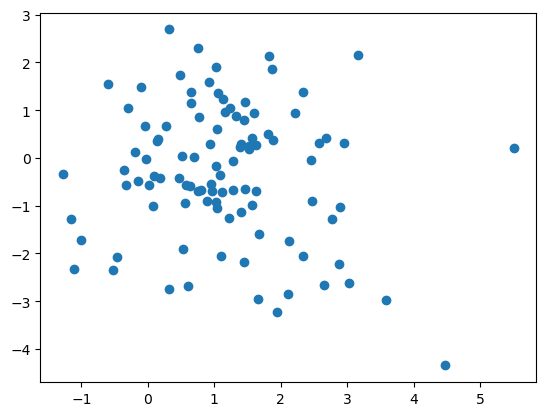

In [108]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

In [70]:
### Training the Generator Model ###

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [71]:

# demonstrate creating the three models in the gan
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 2)                 122       
                                                                 
 sequential_15 (Sequential)  (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [72]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [73]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        

In [88]:
### Evaluate the Performance of the GAN ###

def generate_real_samples(n):
    # generate inputs in [-1, 1]
    X1 = np.random.rand(n) - 1
    # generate outputs 
    logMultiple = np.vectorize(math.exp)
    logMultiple((-X1**2/0.4))
    
    X2 = 0.28209*logMultiple((-X1**2/0.4))
    
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = np.hstack((X1, X2))
    # generate class labels
    y = np.ones((n, 1))
    return X, y


In [89]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [90]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [91]:

# plot real and fake points
def summarize_performance(generator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [92]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

In [93]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

4/4 [==============================] - 0s 1ms/step
1999 0.46000000834465027 0.699999988079071


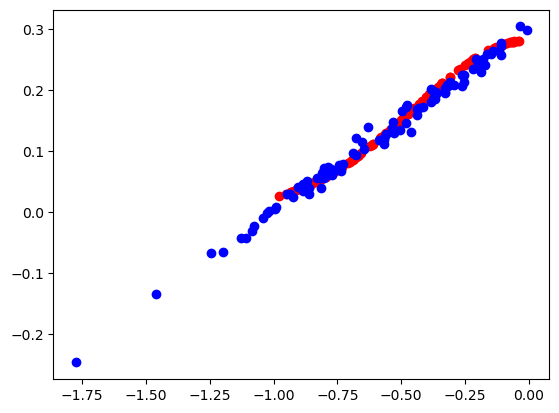

4/4 [==============================] - 0s 1ms/step
3999 0.0 1.0


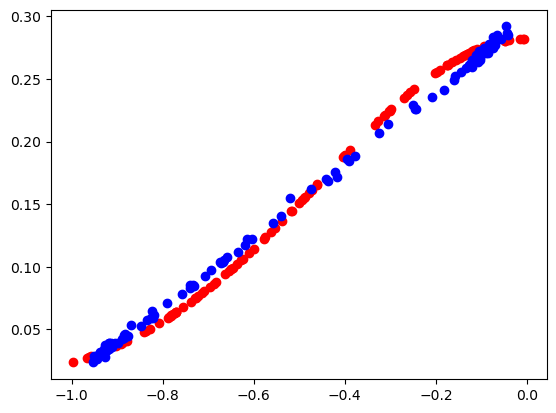

4/4 [==============================] - 0s 997us/step
5999 0.7799999713897705 0.4099999964237213


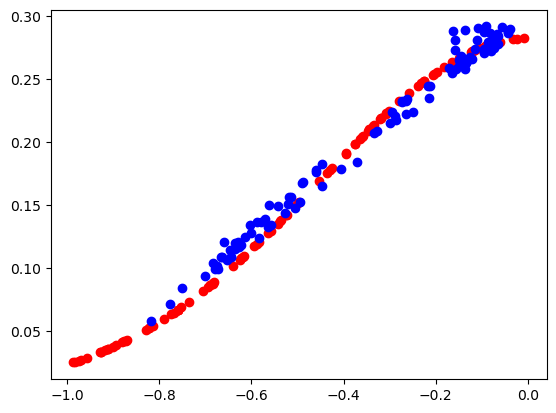

4/4 [==============================] - 0s 1ms/step
7999 0.6399999856948853 0.10000000149011612


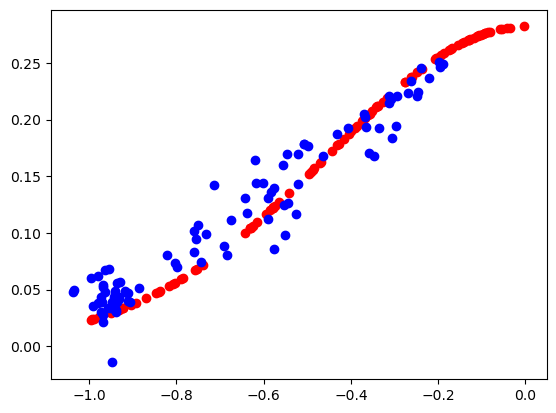

4/4 [==============================] - 0s 1ms/step
9999 0.7300000190734863 0.30000001192092896


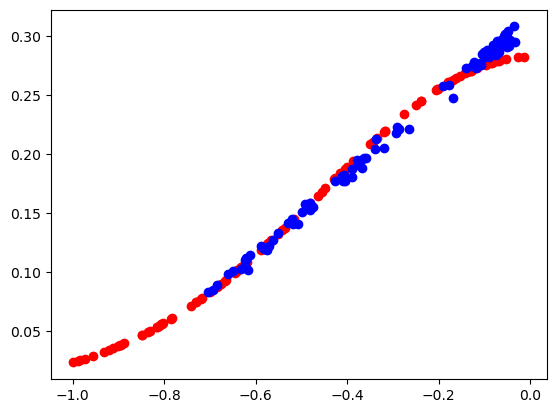

In [94]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

## (Shannon entropy)

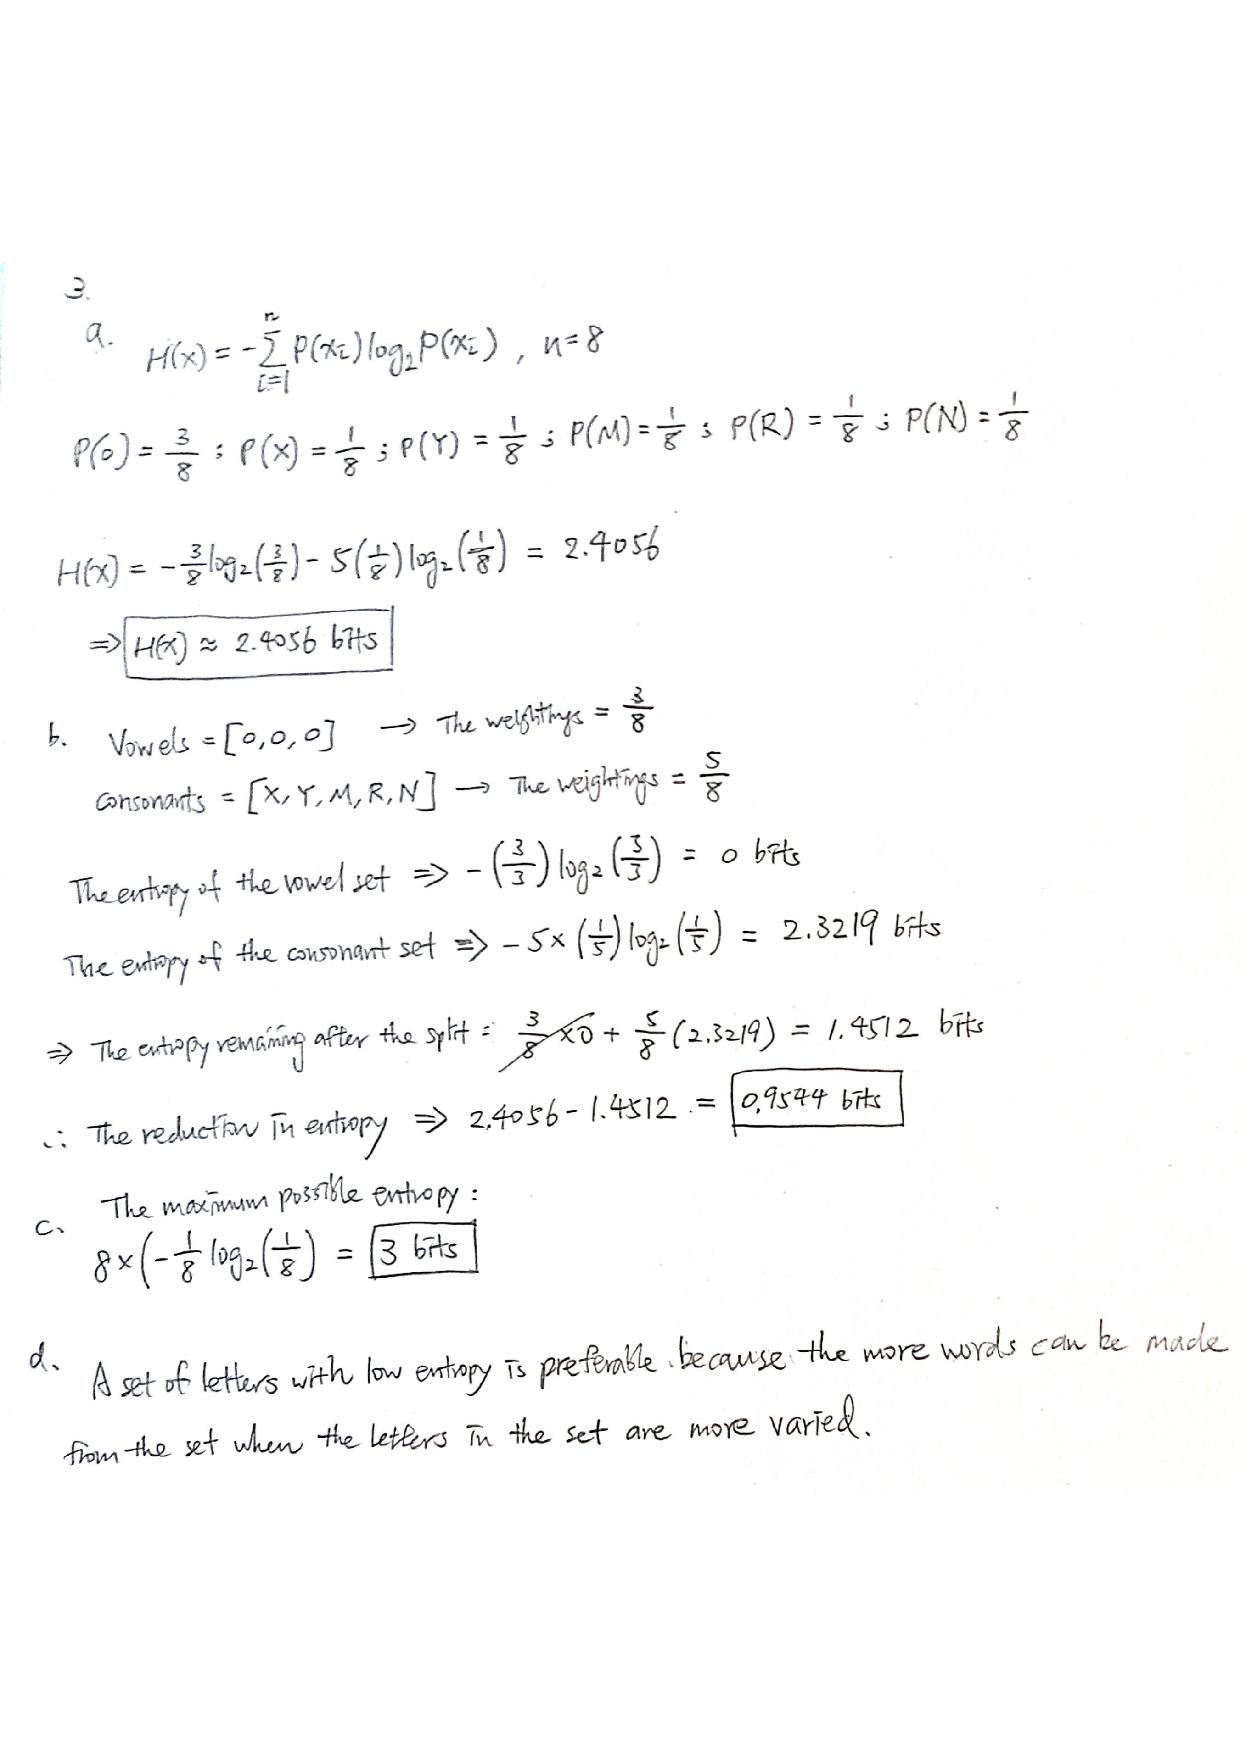